## **Loan Eligibility Prediction Model Using Pipelines**

### Project Scope:

Loans form an integral part of banking operations. However, not all loans are returned and hence it is important for a bank to closely moniter its loan applications. This case study is an analysis of the German Credit data. It contains details of 614 loan applicants with 13 attributes and the classification whether an applicant was granted loan or denied loan.

**Your role:** Using the available dataset, train a classification model to predict whether an applicant should be given loan.

**Goal:** Build a model to predict loan eligiblity with an average acuracy of more than 76%

**Specifics:** 

* Machine Learning task: Classification model 
* Target variable: Loan_Status 
* Input variables: Refer to data dictionary below
* Success Criteria: Accuracy of 76% and above


## Data Dictionary:

* **Loan_ID:** Applicant ID
* **Gender:** Gender of the applicant Male/Female
* **Married:** Marital status of the applicant
* **Dependents:** Number of dependants the applicant has
* **Education:** Highest level of education
* **Self_Employed:** Whether self-employed Yes/No
* **ApplicantIncome:** Income of the applicant
* **CoapplicantIncome:** Income of the co-applicant
* **LoanAmount:** Loan amount requested
* **Loan_Amount_Term:** Term of the loan
* **Credit_History:** Whether applicant has a credit history
* **Property_Area:** Current property location
* **Loan_Status:** Loan approved yes/no

In [1]:
from IPython.display import Image
#Image(filename='.jpg')

## **Data Analysis and Data Prep**

### Loading all the necessary packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer # use either one
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.feature_selection import SelectKBest,chi2 # used for feature selection
from sklearn.tree import DecisionTreeClassifier


# for creating pipelines
from sklearn.pipeline import Pipeline, make_pipeline #we'll see the difference between them

# filter warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [3]:
# Import the data from 'credit.csv'
df = pd.read_csv('loan.csv')
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# check the number of rows and observations
df.shape

(614, 13)

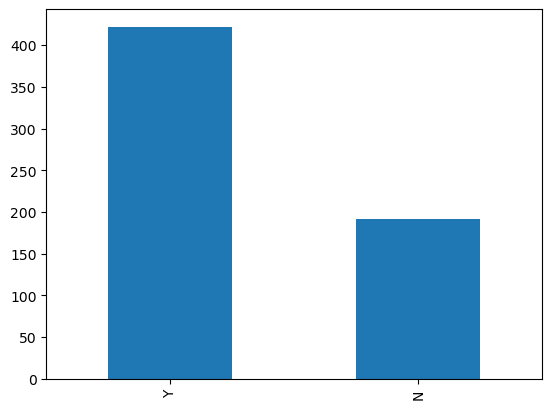

In [5]:
# How many application were approved and how many were denied?
df['Loan_Status'].value_counts().plot.bar()
plt.show()

This is an imbalanced dataset. 422 people (around 69%) out of 614 were eligible for loan

### Data Prep

In [6]:
# drop 'Loan_ID' variable from the data. We won't need it.
df = df.drop('Loan_ID', axis=1)

In [7]:
df.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


### Data Partition

In [8]:
# Separate the input features and target variable
x = df.drop('Loan_Status',axis=1)
y = df.Loan_Status

In [9]:
# splitting the data in training and testing set
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2)

In [10]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((491, 11), (123, 11), (491,), (123,))

In [11]:
xtrain['Gender'].unique(),xtest['Gender'].unique()

(array(['Male', 'Female', nan], dtype=object),
 array(['Female', 'Male', nan], dtype=object))

### Split before pre-processing or imputing.

The division between training and test set is an attempt to replicate the situation where you have past information and are building a model which you will test on future information. If you impute first with train+valid data set and split next, then you have used test data set before you built your model, which is how a data leakage problem comes into picture.

### Column Transformer - Missing value imputation

In [12]:
xtrain.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
35,Male,Yes,0,Graduate,No,2275,2067.0,NaN,360.0,1.0,Urban
160,Male,Yes,0,Not Graduate,No,1863,1041.0,98.0,360.0,1.0,Semiurban


#### Using ColumnTransformer requires naming of steps vs make_column_transformer does not

In [13]:
xtrain.shape

(491, 11)

In [14]:
# Pass a list of tuples to the column transformer
step1 = make_column_transformer(
    (SimpleImputer(strategy='most_frequent'),[0]),
    (SimpleImputer(strategy='most_frequent'),[1]),
    (SimpleImputer(strategy='most_frequent'),[2]),
    (SimpleImputer(strategy='most_frequent'),[3]),
    (SimpleImputer(strategy='most_frequent'),[4]),
    (SimpleImputer(strategy='median'),[5]),
    (SimpleImputer(strategy='median'),[6]),
    (SimpleImputer(strategy='median'),[7]),
    (SimpleImputer(strategy='most_frequent'),[8]),
    (SimpleImputer(strategy='most_frequent'),[9]),
    (SimpleImputer(strategy='most_frequent'),[10]),remainder='passthrough')

# reminder passthrough is not needed here since we have used all of them for imputation. 
# if you choose only few columns for imputation, use this argument otherwhise remaining columns get dropped

It is always better to select columns with index values. Since the output of the column transformer is an array and array' don't hold column names. So it creates issue with the next step input.

## One hot encoding

Apply OneHotEncoding to categorical columns

In [15]:
# one hot encoding

# handle_unknown='ignore' - if in future or during testing there are any new categories, they will be ignored and set to 0

step2 = make_column_transformer((OneHotEncoder(sparse=False,handle_unknown='ignore'), [0,1,2,3,4,10]) ,remainder='passthrough')

## Scaling Data

In [16]:
# Scale all the columns. Since the previous step is going to create new columns and indexing might create issues
step3 = make_column_transformer((MinMaxScaler(),[-2,-3,-4,-5]), remainder='passthrough')

## Feature Selection

In [17]:
# Feature selection
step4 = SelectKBest(chi2,k=10)

## Define Model

In [18]:
# we will try different values for parameters max_depth and min_samples_split of a tree
params = { 'max_depth':[None,1,2,3],
         'min_samples_split':[2,3,4]}

In [19]:
from sklearn.model_selection import GridSearchCV
step5= GridSearchCV(DecisionTreeClassifier(),params,refit=True)

## Pipleline vs Make_Pipeline

Pipeline requires naming the steps, make_pipeline does not.

## 1. `Pipeline` syntax

In [20]:
dtpipe = Pipeline([
    ('impute',step1),
    ('encode',step2),
    ('scale',step3),
    ('select',step4),
    ('train',step5)
])

## 2. `Make_Pipeline` syntax

In [21]:
# To display Pipeline run this code before the running the pipeline.

from sklearn import set_config
set_config(display='diagram')

In [22]:
# train the model
dtpipe.fit(xtrain,ytrain)

Pipeline(steps=[('impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [0]),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [1]),
                                                 ('simpleimputer-3',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [2]),
                                                 ('simpleimputer-4',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [3]),
                                                 ('simpleimpu...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [0, 1, 2, 3, 4, 10])])),
                ('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [-2, -3, -4, -5])])),
                ('select',
                 SelectKBest(score_func=<function chi2 at 0x00000236FDF8DAB0>)),
                ('train',
                 GridSearchCV(estimator=DecisionTreeClassifier(),
                              param_grid={'max_depth': [None, 1, 2, 3],
                                          'min_samples_split': [2, 3, 4]}))])

In [23]:
# Predict
ypred = dtpipe.predict(xtest)

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest,ypred)

0.7967479674796748

In [25]:
# to check the best parameters used by GridSearchCV
dtpipe.named_steps['train'].best_params_

{'max_depth': 3, 'min_samples_split': 2}

### Note:
* #### The feature selection is affecting the accuracy of the model in this case. 
* #### We can also improve the accuracy by tuning the Decision Tree

## Save the Model

In [26]:
import pickle
pickle.dump(dtpipe,open('pickle\pipe.pkl','wb'))

## Cross Validation using Pipeline

Cross validation can be used on the entire pipeline. 
Let' take for e.g. `for CV=5`
1. First the xtrain is split into 5 pieces. 4/5th is used for training data and 1/5th is used for testing data.
2. On the training data it does all steps from 1 to 4 and step 5 to fit the model.
3. on the 1/5th testing data it does steps from 1 to 4 and uses the model to make predictions. And then it calculates the accuracy.
4. This process is repeated 4 more times for other holds (since CV=5).
5. The average accuracy score is returned.

In [27]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(dtpipe, xtrain, ytrain, cv=5, scoring='accuracy').mean()

0.8045145330859615

Here we have used only xtrain. However, CV is done on the entire dataset before train, test split. CV is prefered when the number of observations is too less. since we cannot afford a split with a smaller dataset.
Since the random_state in train_test_split function can create different splits everytime resulting in different scores. That is why we use CV to perform that train_test_split in 5 different ways (with CV=5) and calculate mean score.

## GridSearch using Pipeline

For GridSearch we need the names of the transformers used in the pipe. That is why it is better to use Pipeline 1 syntax.

In [28]:
pipe = Pipeline([
    ('impute',step1),
    ('encode',step2),
    ('scale',step3),
    ('select',step4),
    ('train',step5)
])

In [29]:
pipe.fit(xtrain,ytrain)

Pipeline(steps=[('impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [0]),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [1]),
                                                 ('simpleimputer-3',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [2]),
                                                 ('simpleimputer-4',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [3]),
                                                 ('simpleimpu...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [0, 1, 2, 3, 4, 10])])),
                ('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [-2, -3, -4, -5])])),
                ('select',
                 SelectKBest(score_func=<function chi2 at 0x00000236FDF8DAB0>)),
                ('train',
                 GridSearchCV(estimator=DecisionTreeClassifier(),
                              param_grid={'max_depth': [None, 1, 2, 3],
                                          'min_samples_split': [2, 3, 4]}))])

In [30]:
step5.best_score_ ,  step5.best_params_

(0.8106369820655536, {'max_depth': 3, 'min_samples_split': 3})